# Recurrent Neural Network Assignment
## Gabriel Marcelino, Grant Burk, Eli   
## CST-435
**October 30, 2024**  


## Problem Statement
Goal is to develop a neural network model capable of predicting the next word in a sentence based on a given sequence of words. This model should use a recurrent neural network (RNN), specifically an LSTM architecture, to understand the sequential context of text data. By training on a large corpus of text, the model will be able to suggest the most likely word to follow a given input sequence.

## 1. Import Requirements and Load data


In [11]:
import kagglehub
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
import random
from nltk.tokenize import sent_tokenize
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
import tensorflow as tf


path = kagglehub.dataset_download("mikeortman/wikipedia-sentences")
nltk.download('punkt_tab')

print("Path to dataset files:", path)

# List files in the dataset directory
files = os.listdir(path)
print("Files in dataset:", files)

# Select a subset of files (e.g., first 10 files)
subset_files = files[:10]
print("Subset of files:", subset_files)

# Load and process the subset of files
data = ""
for file in subset_files:
    with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
        data += f.read()

print("Loaded data from subset of files")

# Taking too long to run -> Use only the first 100,000 characters for testing
data = data[:8000000]

Path to dataset files: /Users/gabriel/.cache/kagglehub/datasets/mikeortman/wikipedia-sentences/versions/3
Files in dataset: ['wikisent2.txt']
Subset of files: ['wikisent2.txt']


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/gabriel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Loaded data from subset of files


## 2. Visualize data

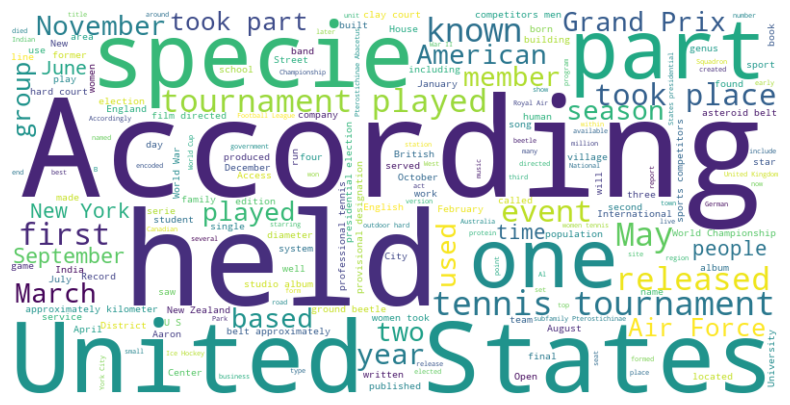

In [12]:
# Visualize data with a word cloud to see most common words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## 3. Prepare Data

In [13]:
# Print sample of raw data
print("Raw data sample:")
print(data[:1000])

# Step 1: Basic text cleaning
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Replace multiple spaces with single space
    text = ' '.join(text.split())
    return text

data = clean_text(data)

# Step 2: Split into sentences
sentences = sent_tokenize(data)

def clean_sentence(sentence):
    # Check if the sentence contains digits
    if re.search(r'\d', sentence):
        return None
    # Modify the regex to keep more punctuation and structure
    sentence = re.sub(r'[^a-z\s.,!?\'"]', '', sentence)  # Remove special characters but keep punctuation
    # Remove extra whitespace
    sentence = ' '.join(sentence.split())
    # Minimum word requirement
    if len(sentence.split()) < 5:  
        return None
    return sentence

# Clean sentences and remove empty ones
sentences = [clean_sentence(sentence) for sentence in sentences]
sentences = [s for s in sentences if s is not None]

print("\nCleaned sentences sample:")
print(sentences[:10])

# Replace the existing tokenizer configuration with:
tokenizer = Tokenizer(
    num_words=20000,  # Limit the vocabulary size to 20,000 words
    oov_token="<OOV>",
    filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n',
    lower=True
)

# Fit the tokenizer on the texts
tokenizer.fit_on_texts(sentences)

# Update the vocab_size variable accordingly
vocab_size = min(len(tokenizer.word_index) + 1, 20000)  # Limit to 20,000 words

# Print vocabulary statistics
print("\nVocabulary statistics:")
print(f"Total unique words: {len(tokenizer.word_index)}")
print(f"Most common words: {list(tokenizer.word_index.items())[:10]}")

# Convert sentences to sequences
sequences = tokenizer.texts_to_sequences(sentences)

print("\nSequence samples:")
print(sequences[:10])


Raw data sample:
0.000123, which corresponds to a distance of 705 Mly, or 216 Mpc.
000webhost is a free web hosting service, operated by Hostinger.
0010x0010 is a Dutch-born audiovisual artist, currently living in Los Angeles.
0-0-1-3 is an alcohol abuse prevention program developed in 2004 at Francis E. Warren Air Force Base based on research by the National Institute on Alcohol Abuse and Alcoholism regarding binge drinking in college students.
0.01 is the debut studio album of H3llb3nt, released on February 20, 1996 by Fifth Colvmn Records.
001 of 3 February 1997, which was signed between the Government of the Republic of Rwanda, and FAPADER.
003230 is a South Korean food manufacturer.
0.04%Gas molecules in soil are in continuous thermal motion according to the kinetic theory of gasses, there is also collision between molecules - a random walk.
0.04% of the votes were invalid.
005.1999.06 is the fifth studio album by the South Korean singer and actress Uhm Jung-hwa.
005 is a 1981 arc

## 4. Create Features and Labels

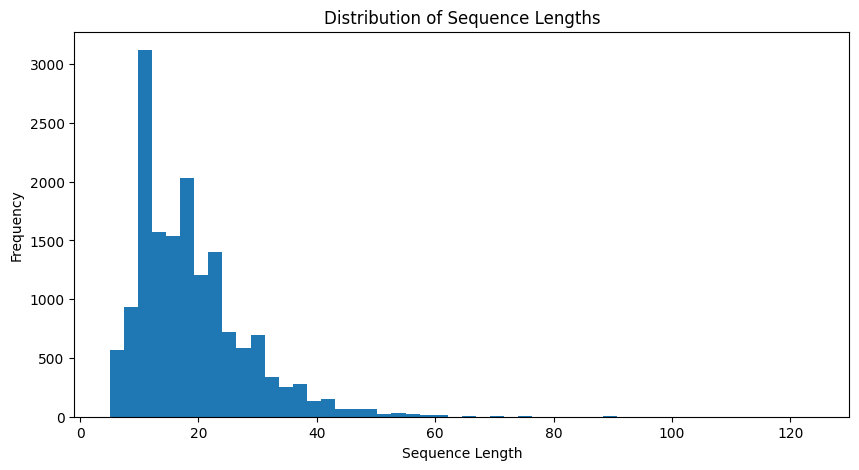

Using max sequence length of 36 (95th percentile)


/var/folders/yl/wjfz8mgx57s1mws2vfhh23000000gn/T/ipykernel_35407/2264902440.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


Dataset shapes after sampling:
X shape: (40000, 35)
y shape: (40000,)

Final shapes:
X_train: (32000, 35)
X_test: (8000, 35)
y_train: (32000, 10000)
y_test: (8000, 10000)


In [14]:
# Step 1: Analyze sequence lengths and set appropriate max length
if len(sequences) == 0:
    raise ValueError("No sequences found in the dataset")

sequence_lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(10, 5))
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

# Set max length based on percentile rather than arbitrary cutoff
max_sequence_len = int(np.percentile([len(seq) for seq in sequences], 95))
print(f"Using max sequence length of {max_sequence_len} (95th percentile)")

# Step 2: Create input-output pairs more efficiently
def create_sequences(sequences, max_length, step=1):
    X, y = [], []
    for sequence in sequences:
        # Pad sequence to max_length
        padded = pad_sequences([sequence], maxlen=max_length, padding='post')[0]
        # Create sequences with sliding window
        for i in range(1, len(padded)):
            X.append(padded[:i])
            y.append(padded[i])
    return np.array(X), np.array(y)

# Create sequences with efficient numpy operations
X, y = create_sequences(sequences, max_sequence_len)

# Step 3: Pad X sequences all at once (more efficient)
X = pad_sequences(X, maxlen=max_sequence_len-1, padding='post')

# Step 4: Handle vocabulary size and rare words
vocab_size = min(len(tokenizer.word_index) + 1, 10000)  # Limit vocab size
y = np.where(y >= vocab_size, tokenizer.word_index['<OOV>'], y)  # Replace rare words with OOV

# Step 5: Sample dataset if too large (using stratified sampling)
max_samples = 40000
if len(X) > max_samples:
    indices = np.random.choice(len(X), max_samples, replace=False)
    X = X[indices]
    y = y[indices]

print(f"Dataset shapes after sampling:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Step 6: Split data more efficiently (no need for chunks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# Step 7: Convert to one-hot encoding
y_train = to_categorical(y_train, num_classes=vocab_size)
y_test = to_categorical(y_test, num_classes=vocab_size)

print("\nFinal shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# Optional: Save some memory
del X, y 

## 5. Build Model

In [15]:


# Load GloVe embeddings
embedding_index = {}
glove_path = 'glove.42B.300d.txt'
if not os.path.exists(glove_path):
    print(
        f"File {glove_path} not found. Please download it from https://nlp.stanford.edu/projects/glove/ and place it in the current directory.")
else:
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs

    print(f"Loaded {len(embedding_index)} word vectors.")

# Create an embedding matrix
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the model with Bidirectional LSTM
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_len - 1, trainable=False),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(256)),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(vocab_size, activation='softmax')
])
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# Update training parameters
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,  # Reduced batch size
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')
    ],
    verbose=1
)
# Save the model after training
model.save('trained_model.h5')
print("Model saved to 'trained_model.h5'")


def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    # Add penalty for recently used tokens
    if hasattr(sample_with_temperature, 'recent_tokens'):
        for token in sample_with_temperature.recent_tokens:
            if token < len(preds):
                preds[token] *= 0.1  # Reduce probability of recent tokens
    
    preds = np.log(preds + 1e-10) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    # Take top 100 predictions only
    top_indices = np.argpartition(preds, -100)[-100:]
    top_preds = preds[top_indices]
    top_preds = top_preds / np.sum(top_preds)
    
    chosen_idx = np.random.choice(top_indices, p=top_preds)
    
    # Update recent tokens
    if not hasattr(sample_with_temperature, 'recent_tokens'):
        sample_with_temperature.recent_tokens = []
    sample_with_temperature.recent_tokens = ([chosen_idx] + sample_with_temperature.recent_tokens)[:3]
    
    return chosen_idx

def predict_next_word(text, num_words=5, temperature=0.7):  
    sequence = tokenizer.texts_to_sequences([text])[0]
    generated_text = []
    # Reset recent tokens at start of generation
    sample_with_temperature.recent_tokens = []
    
    for _ in range(num_words):
        padded = pad_sequences([sequence], maxlen=max_sequence_len - 1, padding='pre')
        
        pred = model.predict(padded, verbose=0)[0]
        next_word_idx = sample_with_temperature(pred, temperature)
        
        # Stop if we hit padding token
        if next_word_idx == 0:
            break
            
        # Stop if we're repeating too much
        if len(generated_text) >= 2 and next_word_idx == sequence[-1] and next_word_idx == sequence[-2]:
            break
            
        sequence.append(next_word_idx)
        next_word = tokenizer.index_word.get(next_word_idx, "")
        if next_word:  # Only add non-empty words
            generated_text.append(next_word)
    
    return " ".join(generated_text)

# Evaluate the model
def evaluate_model():
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nTest Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

# Testing the function
test_sentences = ["He was", "That is"]
for test_sentence in test_sentences:
    completed_text = predict_next_word(test_sentence, num_words=10, temperature=0.7)
    print(f"Original: {test_sentence}")
    print(f"Completed: {test_sentence} {completed_text}")


# Run enhanced evaluation
evaluate_model()


Loaded 1917494 word vectors.
Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 234s 285ms/step - accuracy: 0.4976 - loss: 4.2689 - val_accuracy: 0.5098 - val_loss: 3.6681
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 205s 256ms/step - accuracy: 0.5045 - loss: 3.5956 - val_accuracy: 0.5188 - val_loss: 3.5993
Epoch 3/20
518/800 ━━━━━━━━━━━━━━━━━━━━ 1:06 235ms/step - accuracy: 0.5110 - loss: 3.4370

KeyboardInterrupt: 

## Algorithm of the solution

## Analysis of the findings

## References
